In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import corner
from astropy.cosmology import Planck18
import torch
import zuko
import pandas as pd
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

Using device: cuda:0.


In [4]:
def compare_plot(exp_name, var):

    client = MlflowClient()
    exp_id = client.get_experiment_by_name(exp_name).experiment_id
    run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    full_loss = []
    for i, run_id in enumerate(run_ids):
        loss_history = client.get_metric_history(run_id, 'loss')
        losses = [metric.value for metric in loss_history]
        full_loss.append(losses)
        steps = len(losses)
        artifact_uri = client.get_run(run_id).info.artifact_uri
        sigma = client.get_run(run_id).data.params[var]
        eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
        ax2.plot(eigs, alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=colors[i])
        brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
        ax2.plot(brute_force_eigs, color=colors[i])
    loss = np.array(full_loss)
    for i, run_id in enumerate(run_ids):
        loss_history = client.get_metric_history(run_id, 'loss')
        losses = [metric.value for metric in loss_history]
        full_loss.append(losses)
        steps = len(losses)
        artifact_uri = client.get_run(run_id).info.artifact_uri
        sigma = client.get_run(run_id).data.params[var]
        ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors[i], label=f"{var}={sigma}")

    ax1.set_xlabel("Training Step")
    ax1.set_ylabel("Loss")
    ax1.set_yscale('log')
    ax2.set_xlabel("Design Index")
    ax2.set_ylabel("Expected Information Gain [bits]")
    ax1.legend()
    plt.show()

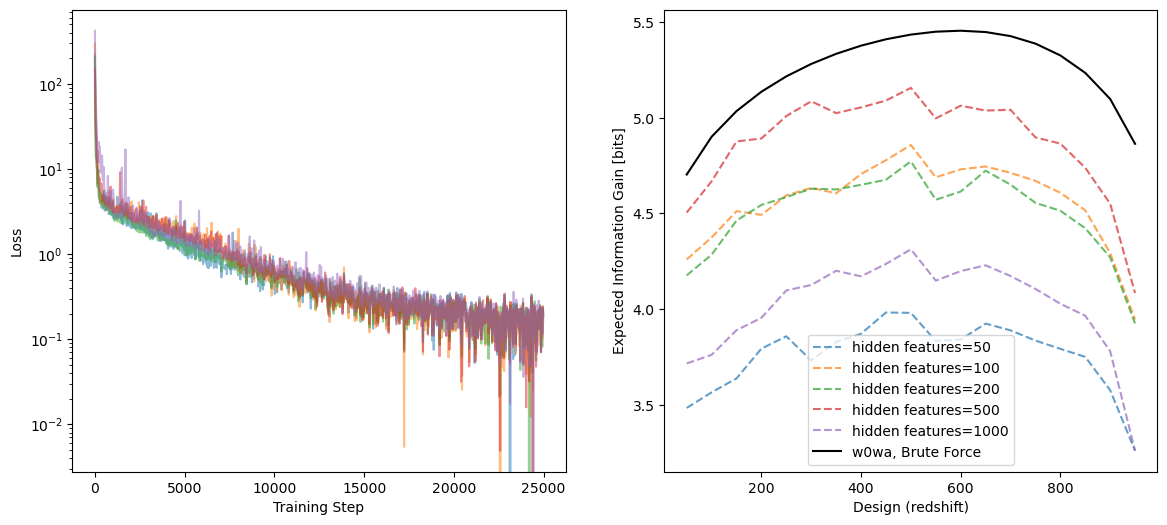

In [ ]:
client = MlflowClient()
exp_name = 'n_tracers_w0wa_hidden'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['hidden']))
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    hidden_features = client.get_run(run_id).data.params['hidden']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"hidden features={hidden_features}", linestyle='--')
w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_prior.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], label="w0wa, Brute Force", color='black')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

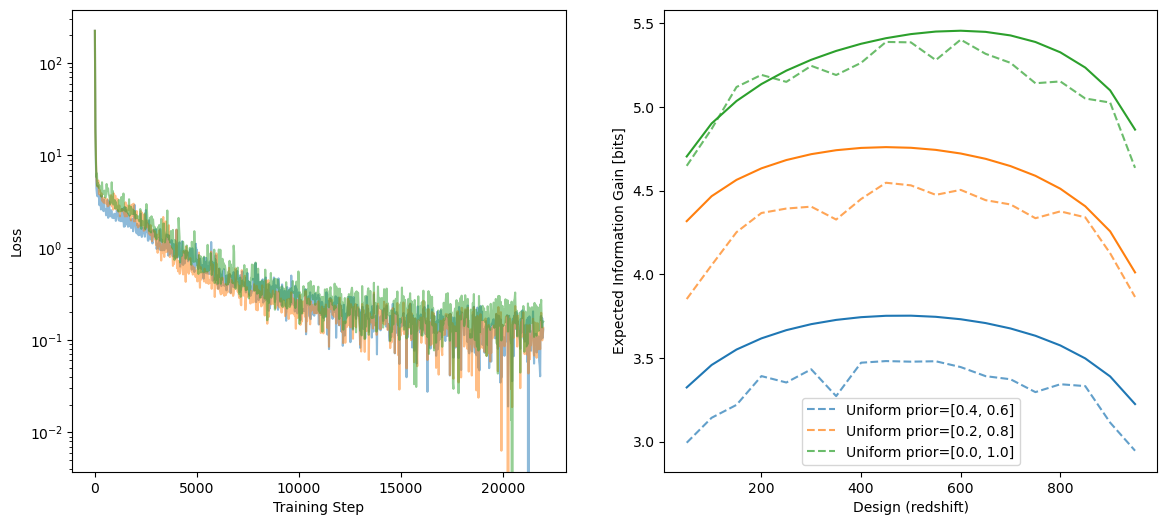

In [35]:
client = MlflowClient()
exp_name = 'n_tracers_prior'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['hidden']))
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    low = client.get_run(run_id).data.params['om_low']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2][::-1], alpha=0.7, label=f"Uniform prior=[{low}, {1-float(low)}]", linestyle='--')
w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_prior.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:green')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_prior_0.2.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:orange')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_prior_0.4.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

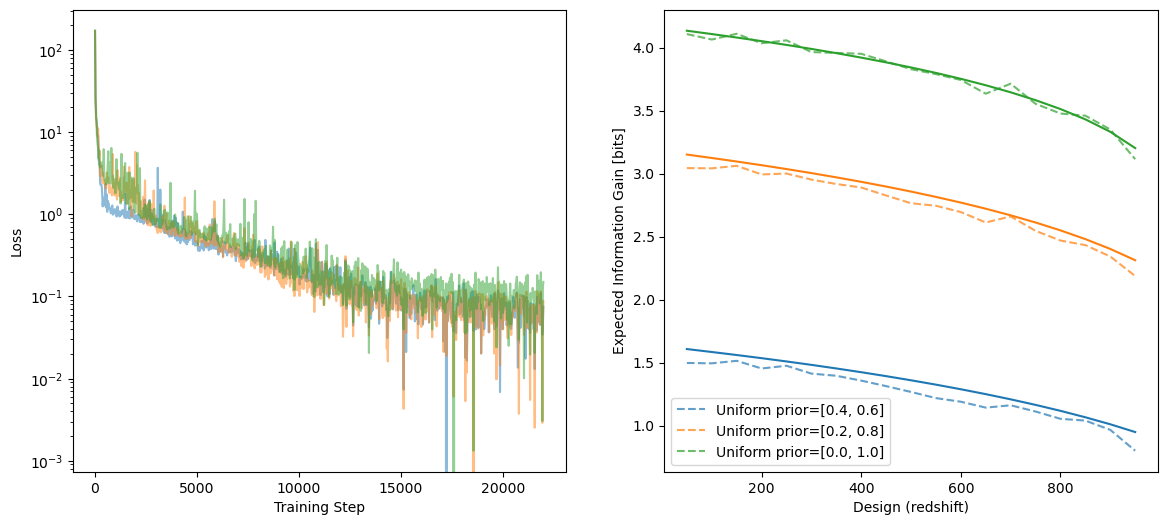

In [29]:
client = MlflowClient()
exp_name = 'n_tracers_Om_prior'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['hidden']))
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    low = client.get_run(run_id).data.params['om_low']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"Uniform prior=[{low}, {1-float(low)}]", linestyle='--')
w0wa_grid_eigs = np.load("n_tracers_Om_eigs_prior.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:green')

w0wa_grid_eigs = np.load("n_tracers_Om_eigs_prior_0.2.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:orange')

w0wa_grid_eigs = np.load("n_tracers_Om_eigs_prior_0.4.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

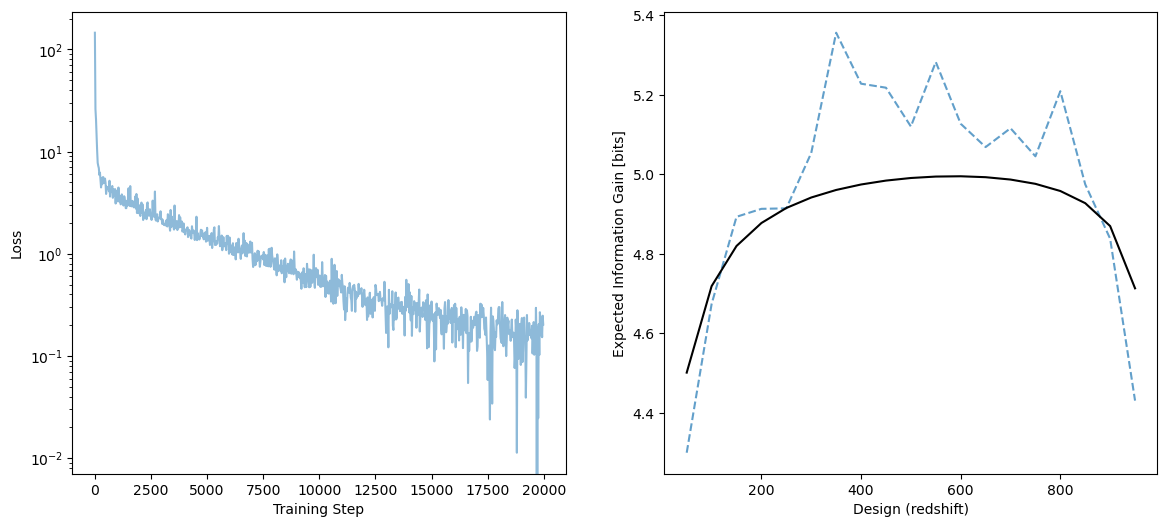

In [4]:
client = MlflowClient()
exp_name = "n_tracers_2D_w0wa"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'lr'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color='black')
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
#ax1.legend()
plt.show()

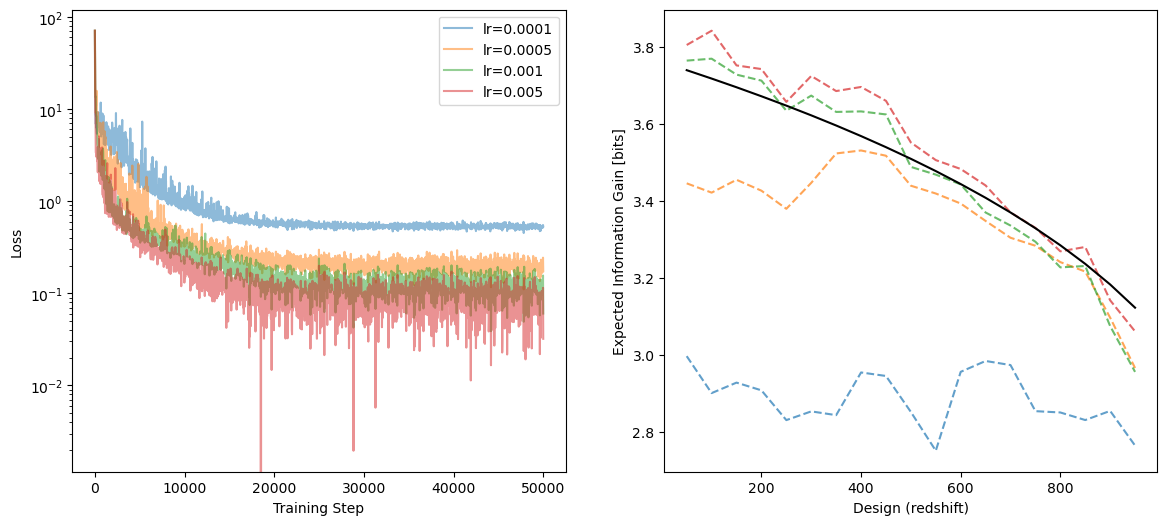

In [4]:

client = MlflowClient()
exp_name = "n_tracers_2D_lr"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'lr'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color='black')
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

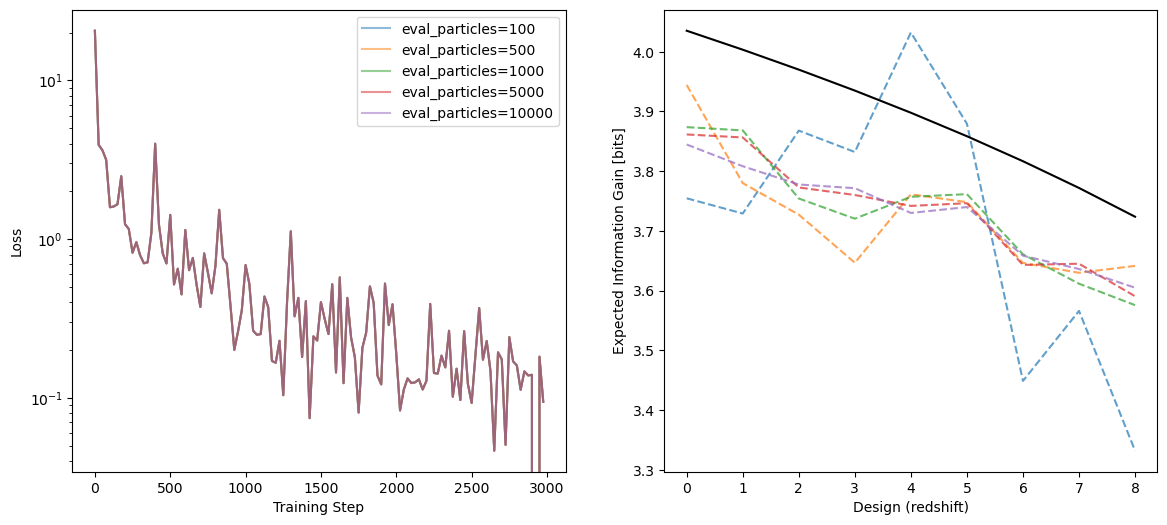

In [13]:
compare_plot("2_tracers_eval", "eval_particles")

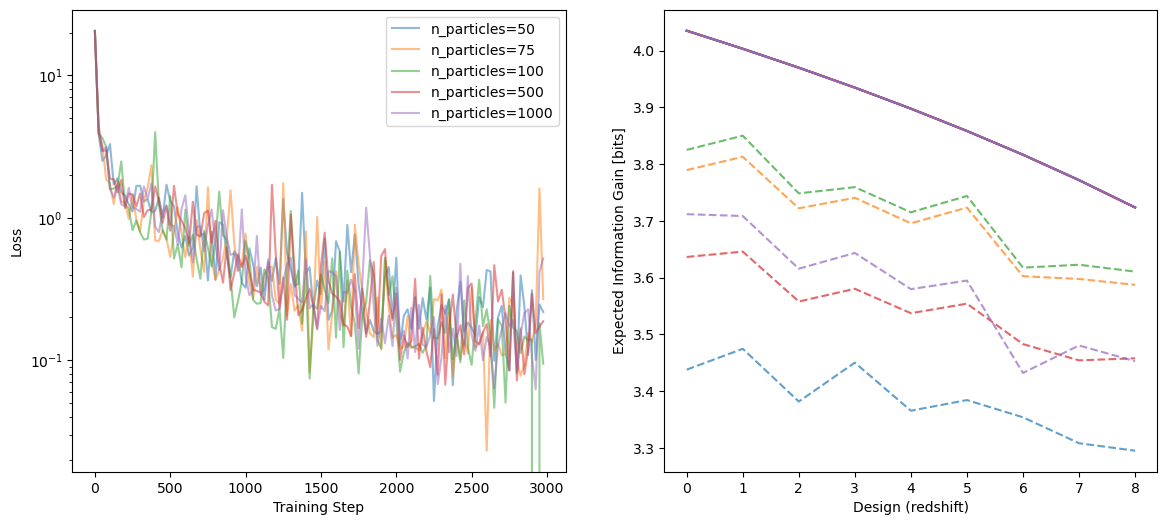

In [26]:
compare_plot("2_tracers_particles", "n_particles")

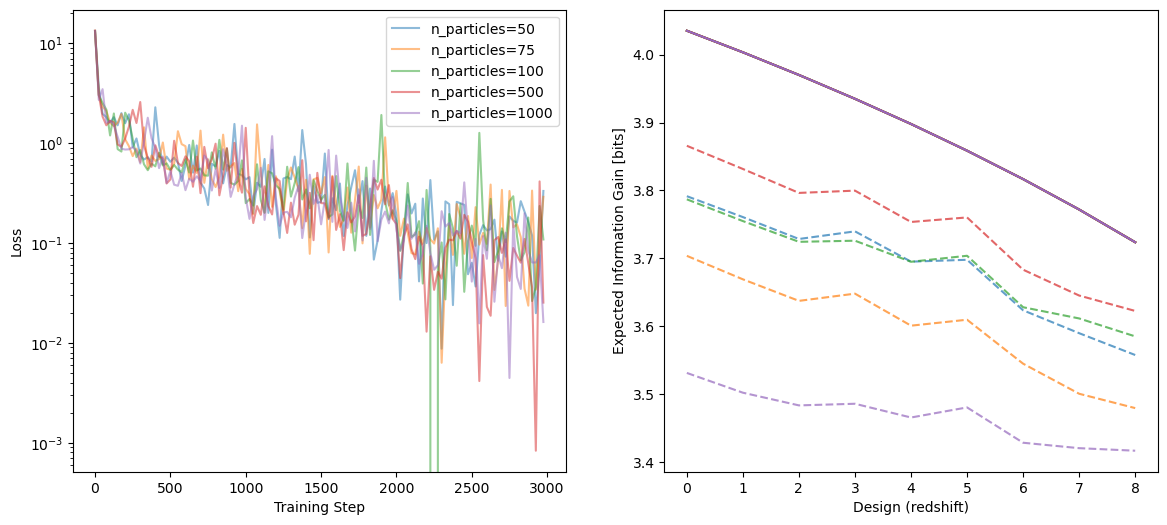

In [27]:
compare_plot("2_tracers_particles_2", "n_particles")

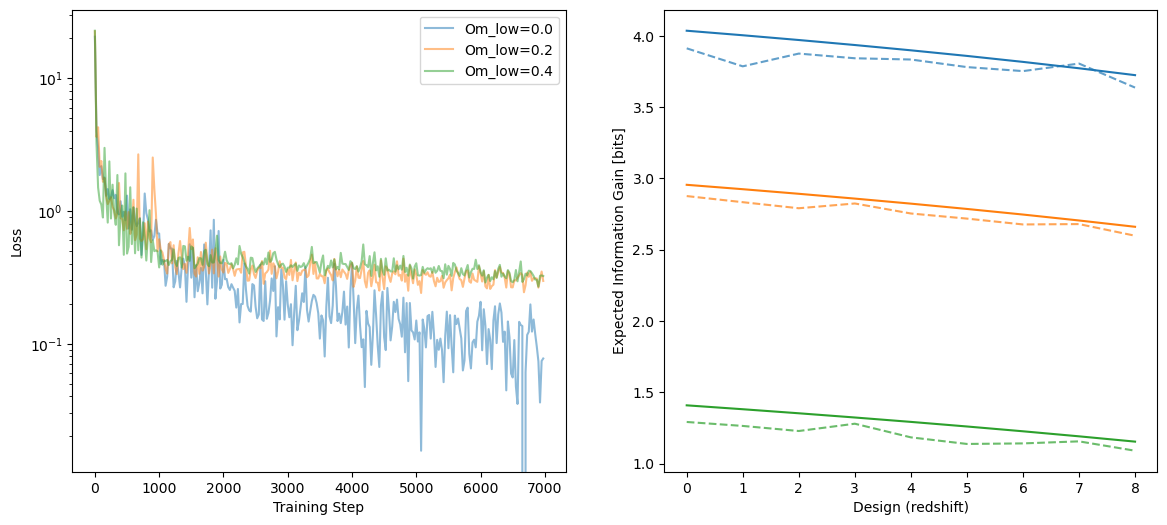

In [29]:
compare_plot("2_tracers_low_1000", "Om_low")

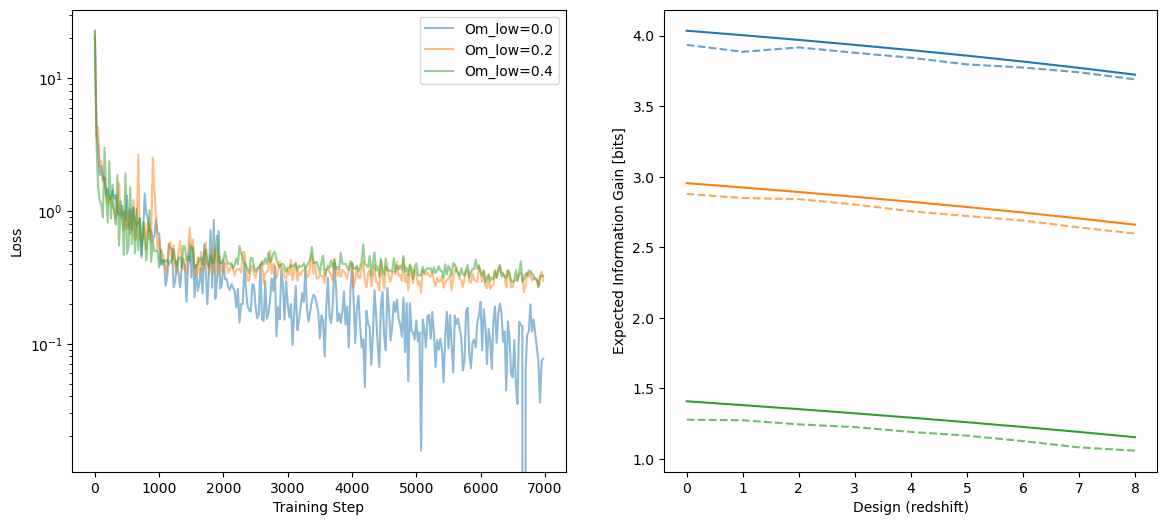

In [3]:
compare_plot("2_tracers_low_10000", "Om_low")

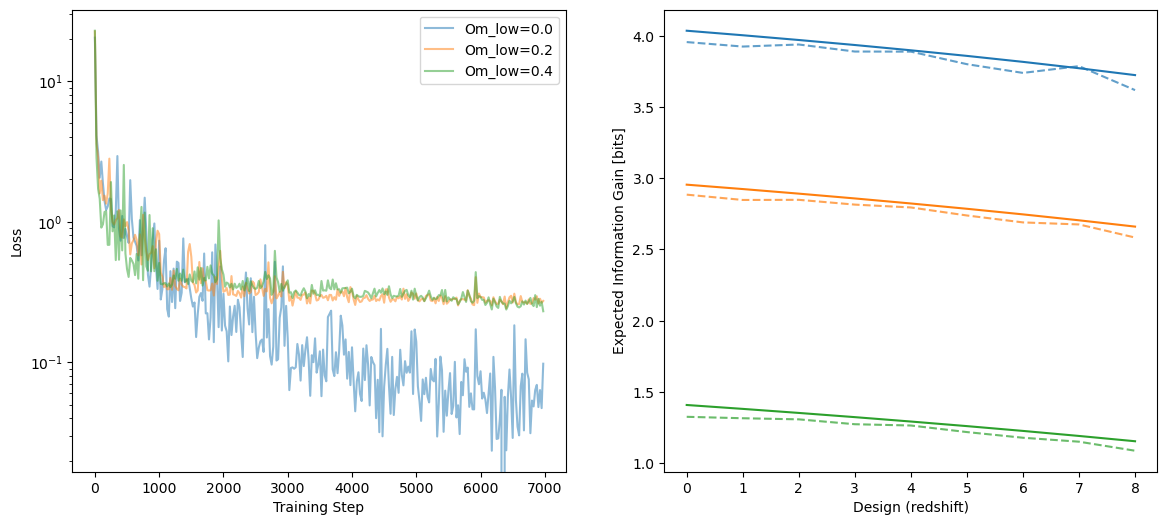

In [19]:
compare_plot("2_tracers_low", "Om_low")

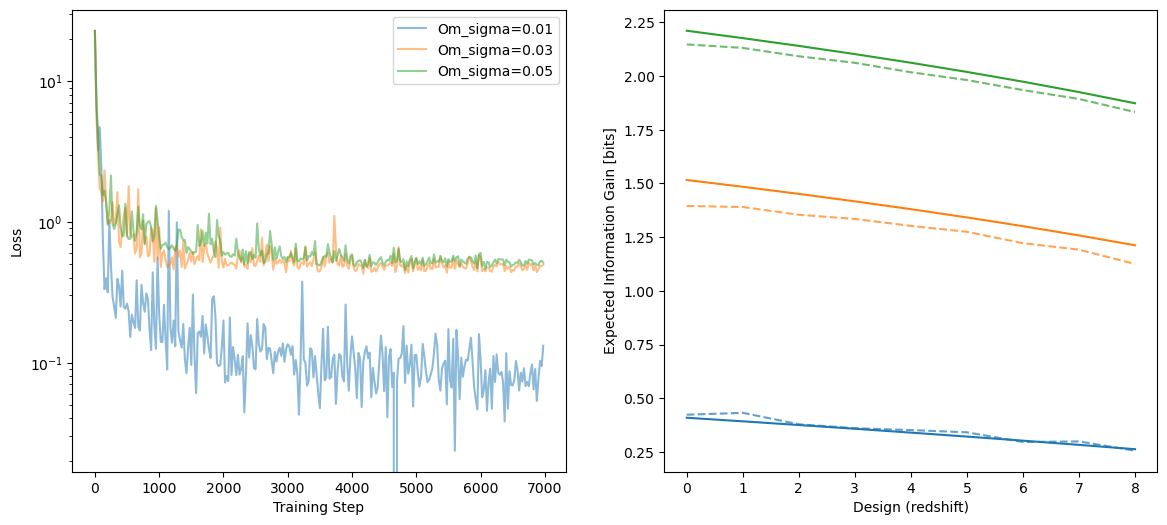

In [3]:
compare_plot("2_tracers_sigma", "Om_sigma")

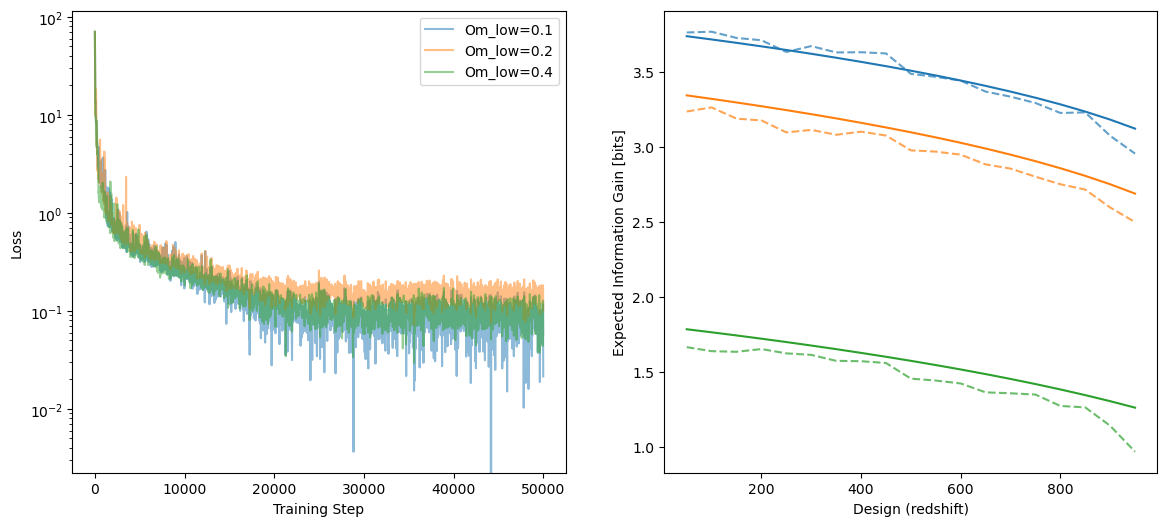

In [ ]:

client = MlflowClient()
exp_name = "n_tracers_2D_low"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

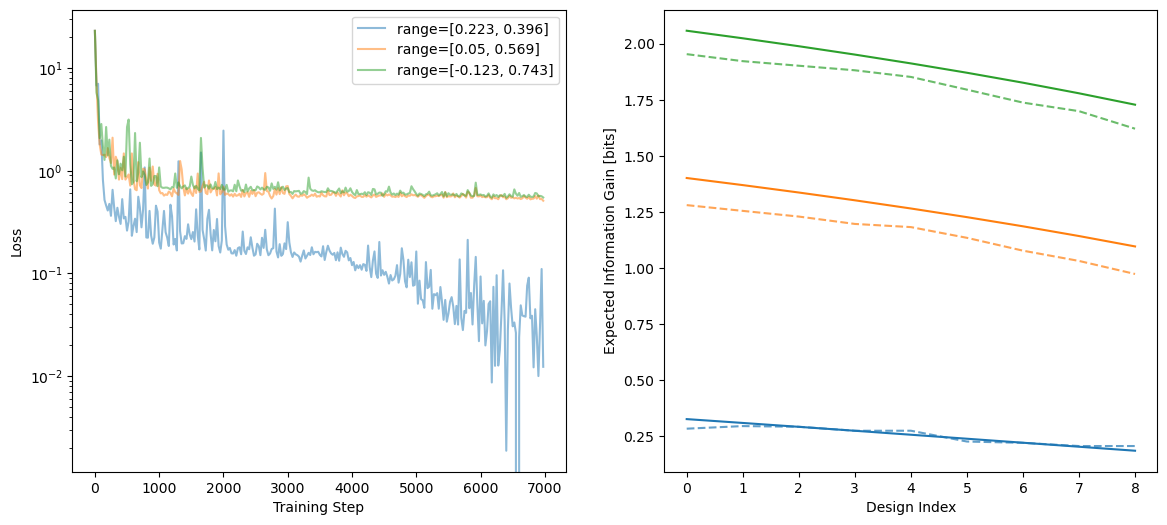

In [ ]:
client = MlflowClient()
exp_name = "2_tracers_flat"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
var = 'Om_scope'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = np.round(float(client.get_run(run_id).data.params[var]),3)
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs, alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs, color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = float(client.get_run(run_id).data.params[var])
    low = np.round(Planck18.Om0 - 5*sigma, 3)
    high = np.round(Planck18.Om0 + 5*
    sigma, 3)
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"range=[{low}, {high}]")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design Index")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

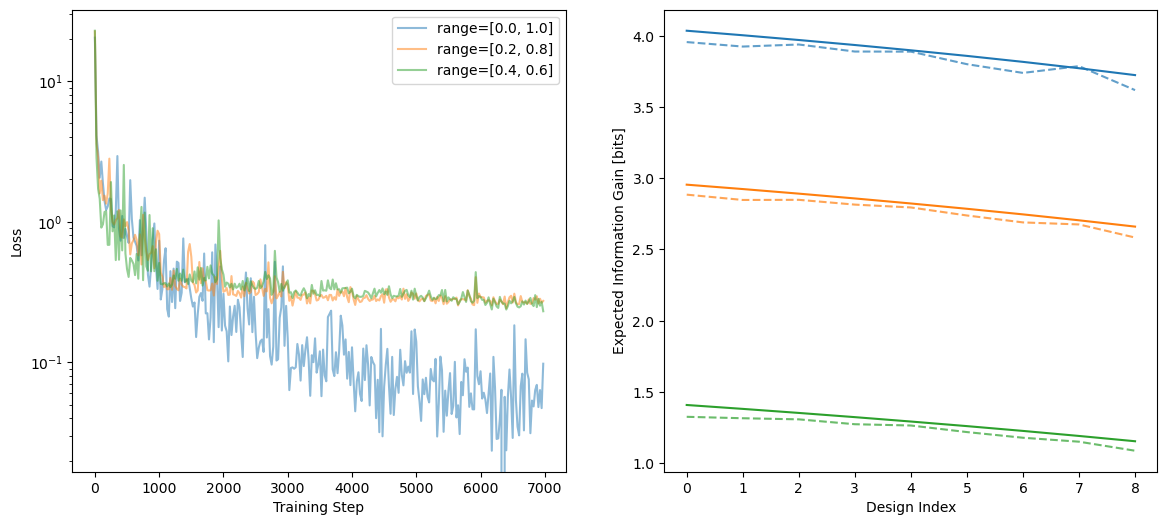

In [3]:
client = MlflowClient()
exp_name = "2_tracers_low"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = np.round(float(client.get_run(run_id).data.params[var]),3)
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs, alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs, color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = float(client.get_run(run_id).data.params[var])
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"range=[{sigma}, {1-sigma}]")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design Index")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

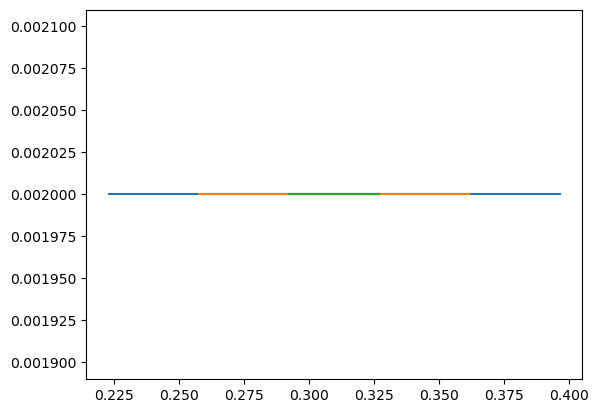

In [ ]:
from bed.grid import Grid, TopHat, CosineBump, Gaussian
from bed.design import ExperimentDesigner
for i in (np.array([0.01, 0.03, 0.05])*np.sqrt(12)/2)[::-1]:

    low = Planck18.Om0 - i
    high = Planck18.Om0 + i
    Om_range = torch.tensor([low, high], device=device)
    grid_params = Grid(Om=np.linspace(*Om_range.cpu().numpy(), 500))
    grid_prior = TopHat(grid_params.Om)
    plt.plot(grid_params.Om, grid_prior)
    grid_prior = Gaussian(grid_params.Om, Planck18.Om0, kwargs["Om_sigma"])
plt.show()

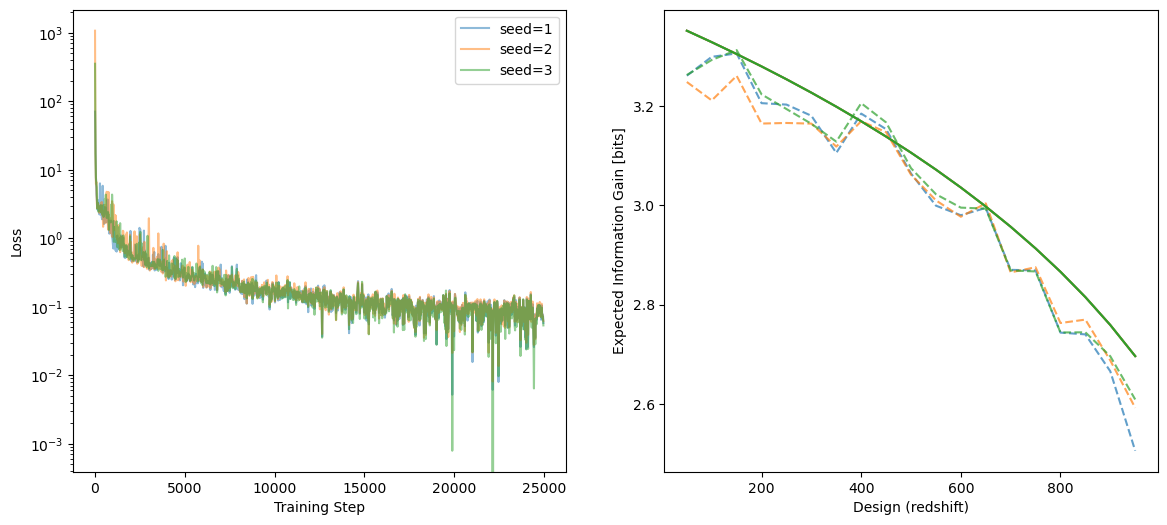

In [10]:

client = MlflowClient()
exp_name = "n_tracers_2D_seed"
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'seed'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

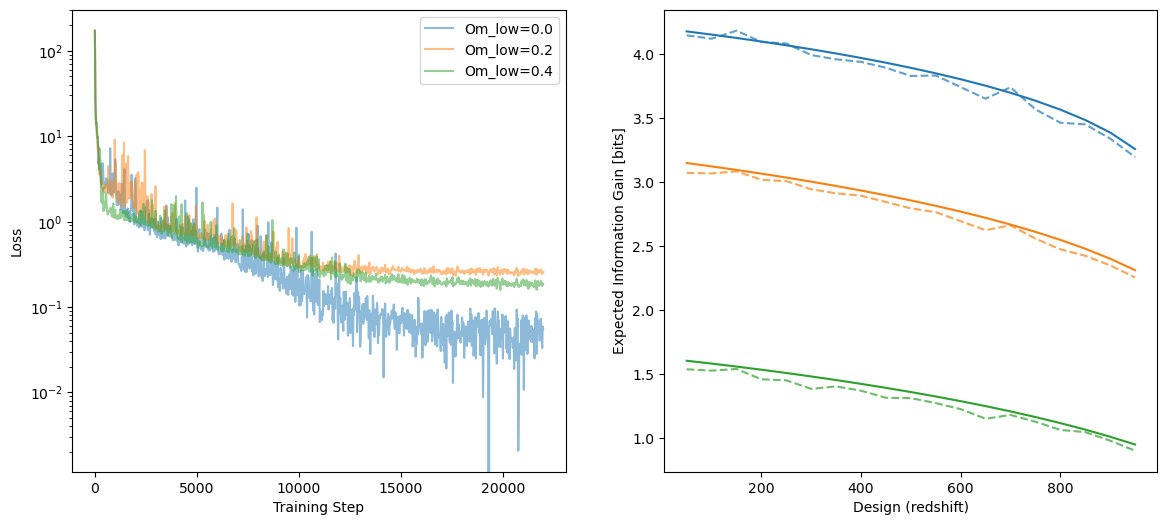

In [15]:

client = MlflowClient()
exp_name = 'n_tracers_Om_flat_low'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

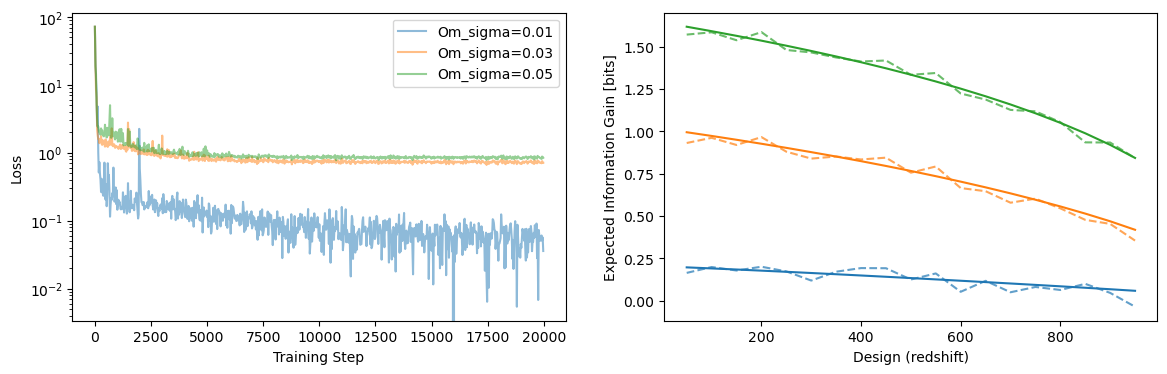

In [8]:

client = MlflowClient()
exp_name = 'n_tracers_2D_w0wa_2.0_sigma'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_sigma'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
final_loss_05 = np.mean(loss[:,-50:], axis=1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

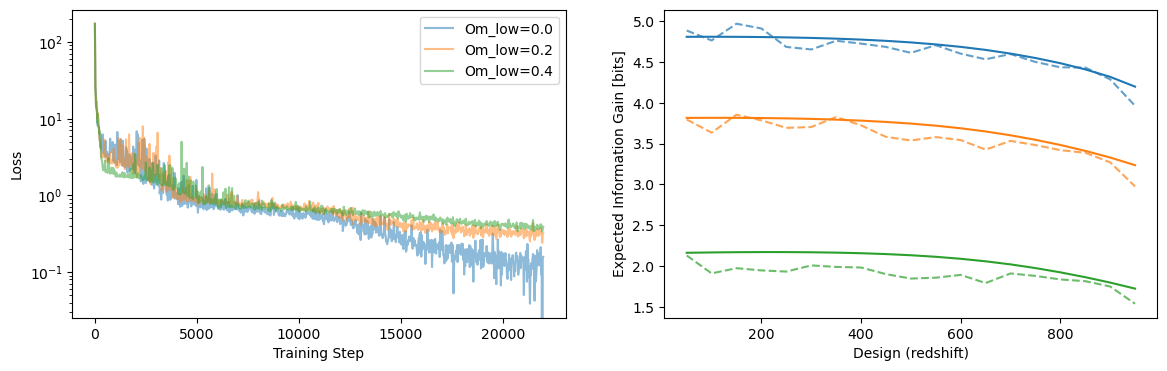

In [50]:

client = MlflowClient()
exp_name = 'n_tracers_Om_flat_0.5'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
final_loss_05 = np.mean(loss[:,-50:], axis=1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

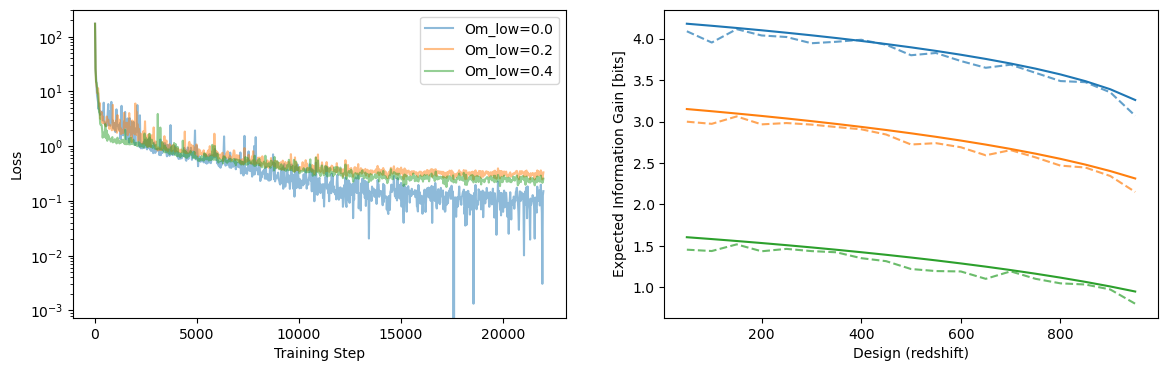

In [49]:

client = MlflowClient()
exp_name = 'n_tracers_Om_flat_1.0'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
final_loss_10 = np.mean(loss[:,-50:], axis=1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

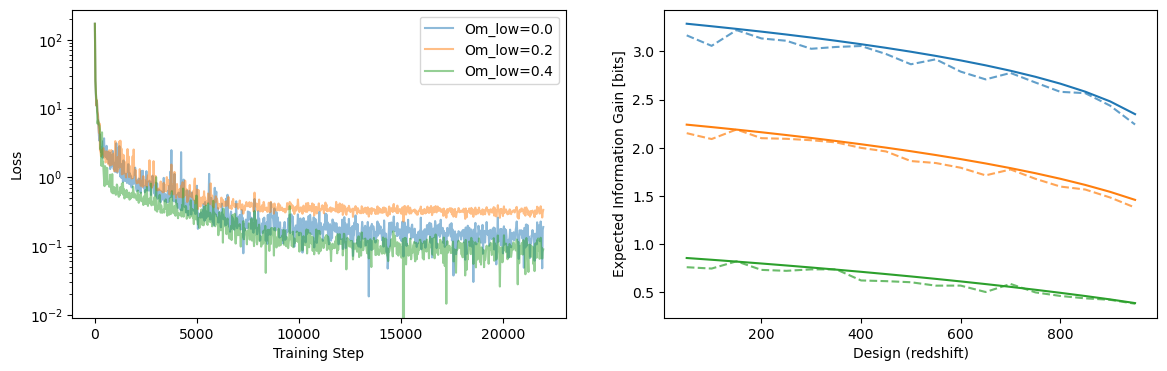

In [47]:

client = MlflowClient()
exp_name = 'n_tracers_Om_flat_2.0'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_low'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
full_loss = []
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    color = colors.pop(0)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=color)
    brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
    ax2.plot(brute_force_eigs[:, 0], brute_force_eigs[:, 1], color=color)
loss = np.array(full_loss)
final_loss_20 = np.mean(loss[:,-50:], axis=1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i, run_id in enumerate(run_ids):
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    full_loss.append(losses)
    steps = len(losses)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors.pop(0), label=f"{var}={sigma}")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
ax1.legend()
plt.show()

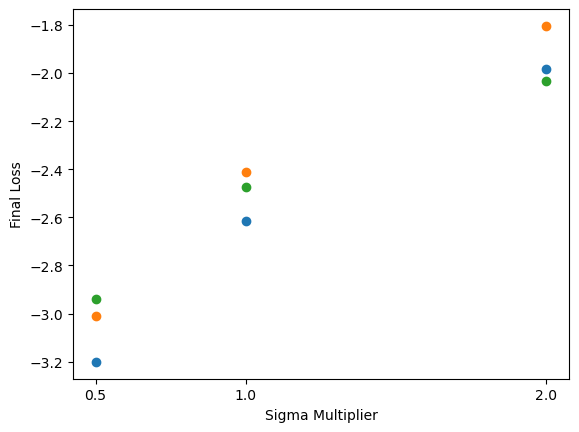

In [51]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(3):
    plt.scatter(0.5, final_loss_05[i], color=colors[i])
    plt.scatter(1.0, final_loss_10[i], color=colors[i])
    plt.scatter(2.0, final_loss_20[i], color=colors[i])
plt.xlabel("Sigma Multiplier")
plt.ylabel("Final Loss")
# show only ticks at 0.5, 1.0, 2.0
plt.xticks([0.5, 1.0, 2.0])
plt.show()

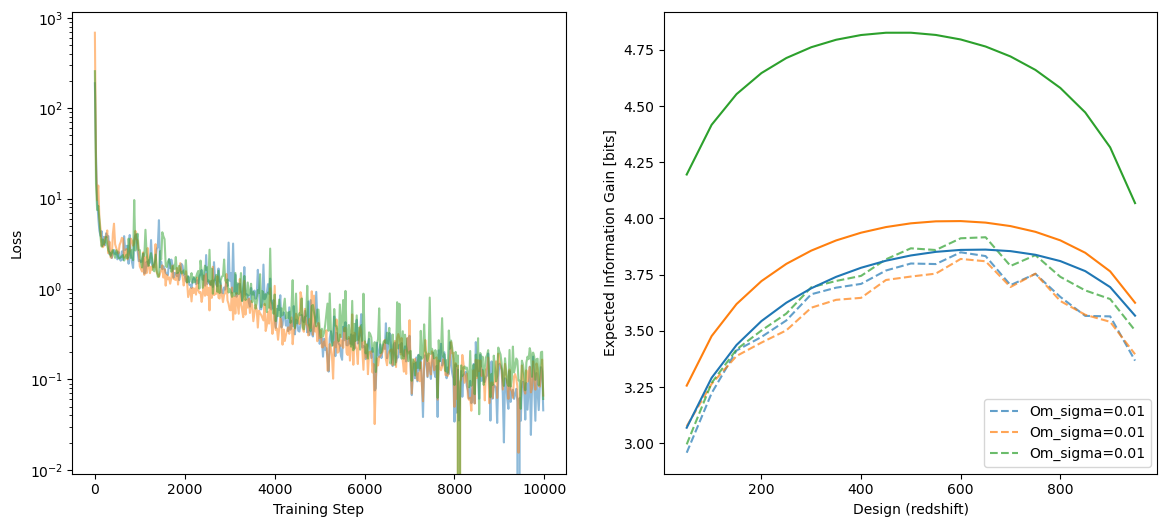

In [25]:
client = MlflowClient()
exp_name = 'n_tracers_w0wa_gaussian_seed'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
var = 'Om_sigma'
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sigma = client.get_run(run_id).data.params[var]
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"{var}={sigma}", linestyle='--')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_gaussian_0.05.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:green')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_gaussian_0.01.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:orange')

w0wa_grid_eigs = np.load("n_tracers_w0wa_eigs_gaussian_0.005.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

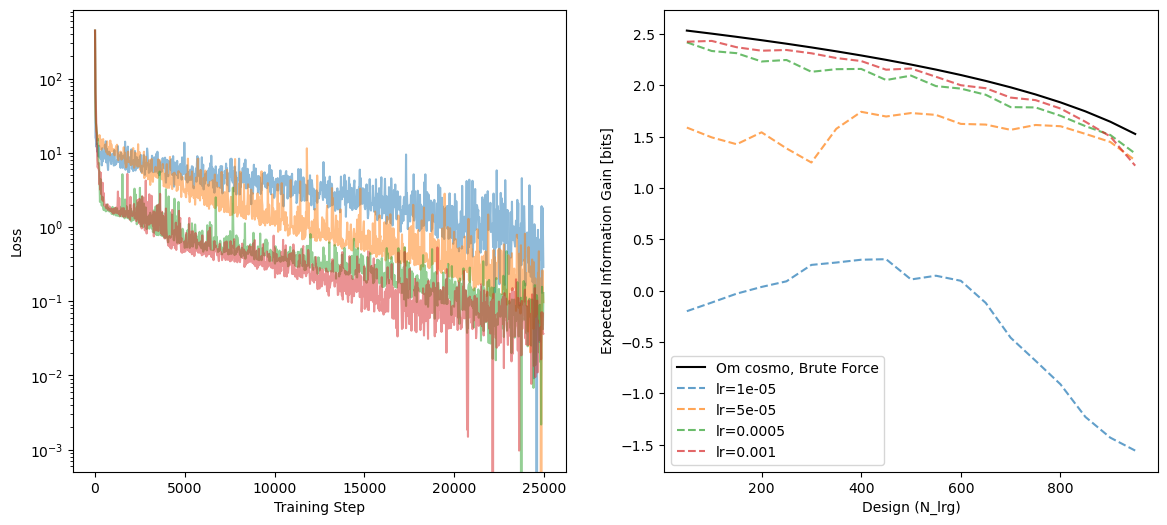

In [34]:
client = MlflowClient()
exp_name = 'n_tracers_lr'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[0:3] + sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[-1:]
ax2.plot(om_grid_eigs[:, 0], om_grid_eigs[:, 1], label="Om cosmo, Brute Force", color='black')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    lr = client.get_run(run_id).data.params['lr']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"lr={lr}", linestyle='--')
om_grid_eigs = np.load("n_tracers_Om_eigs.npy")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (N_lrg)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

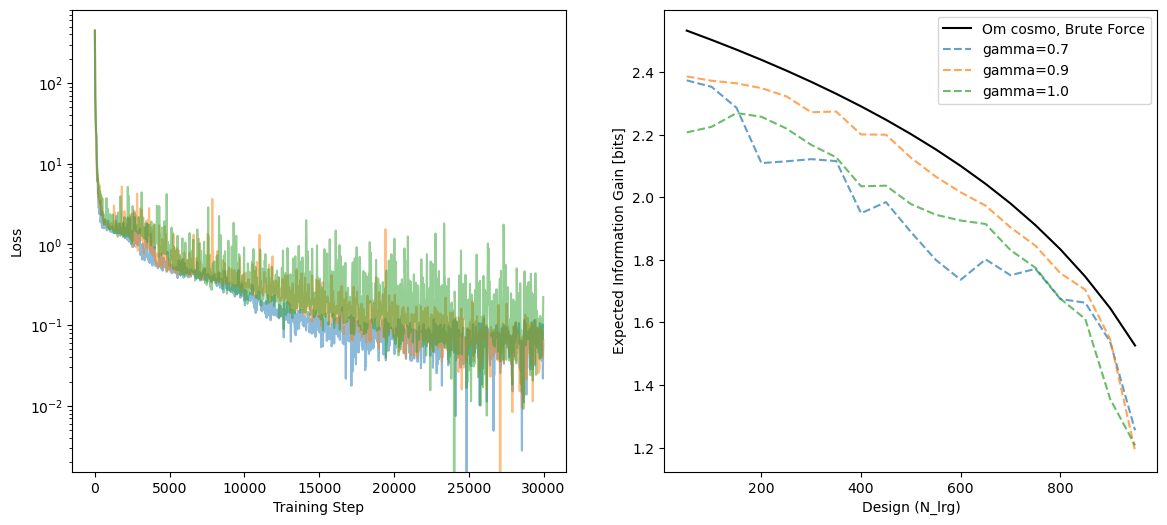

In [4]:
client = MlflowClient()
exp_name = 'n_tracers_gamma'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['gamma']))
om_grid_eigs = np.load("n_tracers_Om_eigs.npy")
ax2.plot(om_grid_eigs[:, 0], om_grid_eigs[:, 1], label="Om cosmo, Brute Force", color='black')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    gamma = client.get_run(run_id).data.params['gamma']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"gamma={gamma}", linestyle='--')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (N_lrg)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

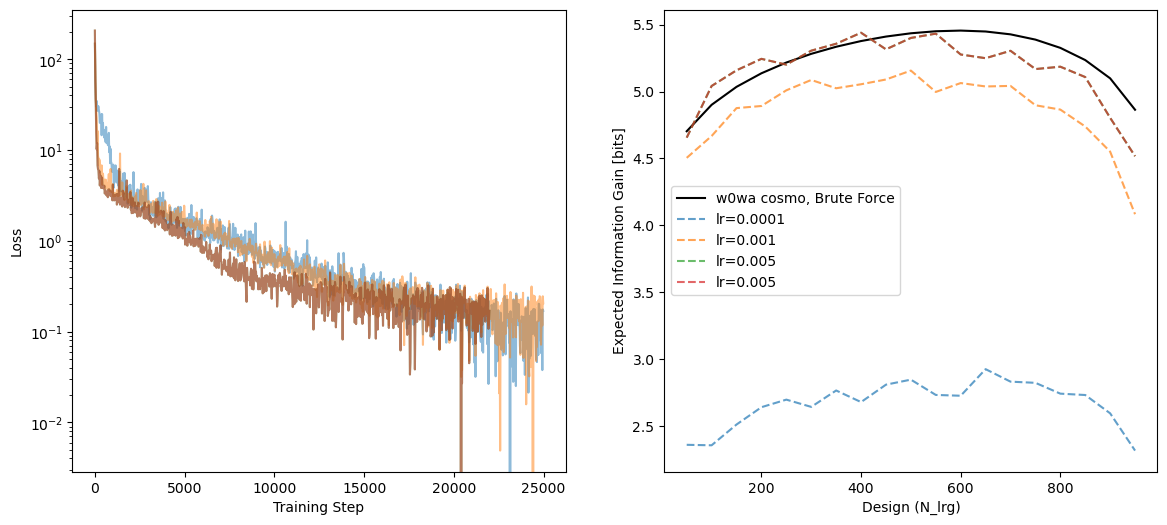

In [6]:
client = MlflowClient()
exp_name = 'n_tracers_w0wa_lr'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[0:3] + sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['lr']))[-1:]
grid_eigs = np.load("n_tracers_w0wa_eigs_prior.npy")
ax2.plot(grid_eigs[:, 0], grid_eigs[:, 1], label="w0wa cosmo, Brute Force", color='black')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    lr = client.get_run(run_id).data.params['lr']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,2], alpha=0.7, label=f"lr={lr}", linestyle='--')


ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (N_lrg)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

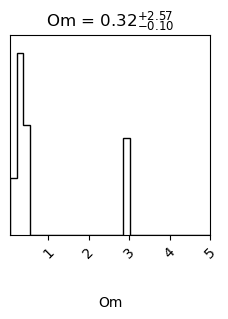

In [60]:
posterior_flow = zuko.flows.MAF(
            features=1, 
            context=4, 
            transforms=10,
            univariate=zuko.transforms.MonotonicRQSTransform,
            shapes = ([24], [24], [23]),
            hidden_features=(500, 1000, 1000),  
        ).to("cuda:0")

checkpoint = torch.load('mlruns/206615824822841321/530eb8612af341138d1a3f8001d756a6/artifacts/nf_checkpoint.pt', map_location="cuda:0")
posterior_flow.load_state_dict(checkpoint['model_state_dict'])
posterior_flow.to("cuda:0")

context = torch.tensor([500, 500, 19.993, 8.620], device="cuda:0")
posterior_samples = posterior_flow(context).sample((20000,)).cpu().detach().numpy()

target_labels = ["Om"]
corner.corner(posterior_samples, labels=target_labels, show_titles=True, title_fmt=".2f", 
                       title_kwargs={"fontsize": 12}, ranges=[0.99]*len(target_labels), bins=30)
plt.show()

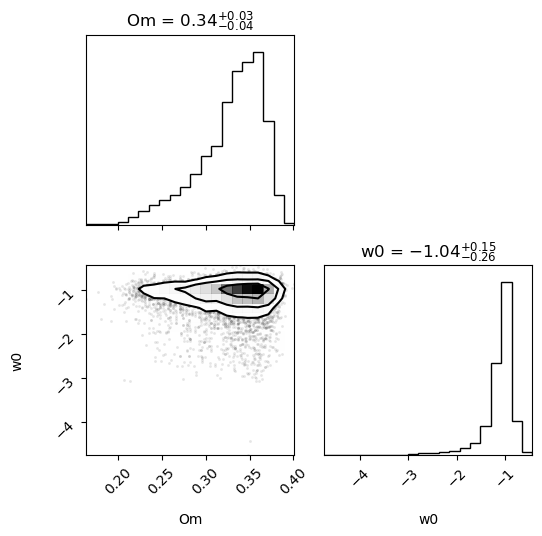

In [6]:
posterior_flow = zuko.flows.MAF(
            features=2, 
            context=4, 
            transforms=10,
            univariate=zuko.transforms.MonotonicRQSTransform,
            shapes = ([24], [24], [23]),
            hidden_features=(500, 1000, 1000),  
        ).to("cuda:0")

checkpoint = torch.load('mlruns/206615824822841321/3791607d12d04cc3a4647ccdffd58f45/artifacts/nf_checkpoint.pt', map_location="cuda:0")
posterior_flow.load_state_dict(checkpoint['model_state_dict'])
posterior_flow.to("cuda:0")

context = torch.tensor([500, 500, 19.993, 8.620], device="cuda:0")
posterior_samples = posterior_flow(context).sample((10000,)).cpu().detach().numpy()

target_labels = ["Om", "w0"]
corner.corner(posterior_samples, labels=target_labels, show_titles=True, title_fmt=".2f", 
                       title_kwargs={"fontsize": 12}, ranges=[0.99]*len(target_labels))
plt.tight_layout()
plt.show()